In [1]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
MAX_TOWERS = 6
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_train():
    train_main = pd.read_csv("../data/task1/train_1.7.csv", encoding="cp1251")
    train_aux_coords = pd.read_csv("../data/task1_additional/coords_train_1.1.csv", encoding="cp1251")
    train_aux_frac = pd.read_csv("../data/task1_additional/frac_train_1.csv", encoding="cp1251")
    train_aux_gdis = pd.read_csv("../data/task1_additional/gdis_train1.2.csv", encoding="cp1251")
    return train_main

train = get_train()

def get_test():
    test_main = pd.read_csv("../data/task1/test_1.9.csv", encoding="cp1251")
    test_aux_coords = pd.read_csv("../data/task1_additional/coords_train_1.1.csv", encoding="cp1251")
    test_aux_frac = pd.read_csv("../data/task1_additional/frac_test_1.csv", encoding="cp1251")
    test_aux_gdis = pd.read_csv("../data/task1_additional/gdis_test1.2.csv", encoding="cp1251")
    return test_main

test = get_test()





In [3]:
#sort by converted date and group
def convert_and_sort(df):
    df["Дата"] =  df["Дата"].apply(pd.to_datetime)
    df.sort_values(by=["Скважина", "Дата"], inplace=True)
    
convert_and_sort(train)

In [4]:
#find columns with same value(useless) in train
def get_non_useful(df):
    non_useful_columns = []
    for c in df.columns:
        null_columns = df[df[c].isnull()]
        if len(null_columns)== len(df):
            non_useful_columns.append(c)
    return non_useful_columns

def drop_non_useful(train, test):
    non_useful = set(get_non_useful(train)) |set(get_non_useful(test))
    print("%s dropped"% non_useful)
    train.drop(list(non_useful), axis=1, inplace=True)
    test.drop(list(non_useful), axis=1, inplace=True)
    
drop_non_useful(train, test)

{'Агент закачки', 'Станок-качалка', 'Тип газосепаратора', 'Примечание', 'Фирма ГРП'} dropped


In [5]:
def get_target(df, column="Нефть, т"):
    target = df[column]
    df.drop([column], axis=1, inplace=True)
    print("%s dropped"% column)
    return target

#remove target from train
y_train = get_target(train)

Нефть, т dropped


In [6]:
#drop non present columns in test
def drop_not_present(train, test):
    absent_columns = list(set(train.columns) - set(test.columns))
    print("%s dropped"% absent_columns)
    train.drop(absent_columns, axis=1, inplace=True)

drop_not_present(train, test)

['Нефть, м3', 'ТП(ГРП) Дебит жидкости', 'ГП - Общий прирост Qн', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Дебит жидкости', 'ТП(ИДН) Дебит жидкости скорр-ый', 'ТП(ИДН) Дебит жидкости', 'Жидкость, м3'] dropped


In [7]:
len(train.columns)== len(test.columns)

True

In [8]:
def show_uniq_test_train(train, test):
    #check all values that have zero ans nan only
    for c in train.columns:
        un = train[c].unique()
        if len(un)<100:
            tun = test[c].unique()
            print("%s ;train: %s; test:%s"%(c, un, tun))

In [9]:
def split_continious_date_categorical_text(df):
    group_id = ["Скважина"]
    text = ["Причина простоя",
            "Куст",
            "Состояние на конец месяца",
            "Причина простоя.1",
            "Мероприятия"]
    categorical = ["Тип скважины",
                   "Неустановившийся режим",
                   "ГТМ",
                   "Метод",
                   "Характер работы",
                   "Состояние",
                   "Пласт МЭР", 
                   "Способ эксплуатации", 
                   "Тип насоса", 
                   "Состояние на конец месяца", 
                   "Номер бригады", 
                   "Фонтан через насос", 
                   "Нерентабельная",
                   "Назначение по проекту",
                   "Группа фонда",
                   "Тип дополнительного оборудования",
                   "Марка ПЭД",
                   "Тип ГЗУ",
                   "ДНС",
                   "КНС",
                   #useless potentially
                   "Диаметр плунжера",
                   "Природный газ, м3",
                   "Конденсат, т",
                   "Длина хода плунжера ШГН",
                   "Коэффициент подачи насоса",
                   "Дебит конденсата",
                   "Вязкость воды в пластовых условиях",
                   "Газ из газовой шапки, м3",
                   "Число качаний ШГН",
                   "Коэффициент сепарации",
                   "SKIN",
                   "КН закрепленный",
                   # radically different
                   "Время в работе",
                   "Радиус контура питания",
                   "Время в накоплении",
                   "Время накопления"
                   ]
    dates = ["Дата", 
             "Дата ГРП",
             "Время до псевдоуст-ся режима", 
             "Дата запуска после КРС", 
             "Дата пуска", 
             "Дата останова",
             "Дата ввода в эксплуатацию"]
    continious = list(set(df.columns) - set(dates) - set(categorical) - set(text) - set(group_id))
    return (df[group_id],df[continious], df[dates], df[categorical], df[text])

train_group, train_cont, train_dat, train_cat, train_text = split_continious_date_categorical_text(train)
test_group, test_cont, test_dat, test_cat, test_text = split_continious_date_categorical_text(test)

In [10]:
def get_object_columns(df):
    objects = []
    for c in df.columns:
        if df[c].dtype != pd.np.float:
            objects.append(c)
    return objects

def get_float(v):
    v = str(v)
    if v != "NaN":
        new = v.replace(",",".")
        return float(new)
    return v

def convert_locale_to_float(df):
    loc_float = get_object_columns(df)
    for c in loc_float:
        df.loc[:,c] = df[c].apply(get_float)
        
convert_locale_to_float(train_cont)
convert_locale_to_float(test_cont)

/anaconda2/envs/env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
def fill_with_mean(train, test):
    means=train.mean()
    norm_train = train.fillna(means)
    norm_test = test.fillna(means)
    return norm_train, norm_test
        
train_cont, test_cont = fill_with_mean(train_cont, test_cont);

In [12]:
train_cont.isnull().values.any() or test_cont.isnull().values.any()

False

In [13]:
#clear nans in target
indexes_to_delete = y_train[y_train.isnull()].index
y_train = y_train[~y_train.isnull()]
train_cont = train_cont.drop(index=indexes_to_delete)
y_train = y_train.apply(get_float)
print(len(y_train) == len(train_cont))

train_group = train_group.drop(index=indexes_to_delete)
print(len(y_train) == len(train_group))

train_cat = train_cat.drop(index=indexes_to_delete)
print(len(y_train) == len(train_cat))

True
True
True


In [29]:
def transform_cats_to_labels(train_cat, test_cat):
    transformed_df = train_cat.copy()
    trans_test = test_cat.copy()
    for c in train_cat.columns:
        encoder = LabelEncoder()
        column_train = train_cat[c].astype(str)
        column_test = test_cat[c].astype(str)
        combined = pd.concat([column_train, column_test])
        encoder.fit(combined)
        transformed_df[c] = encoder.transform(column_train).reshape(-1,1)
        trans_test[c] = encoder.transform(column_test).reshape(-1,1)
    return transformed_df, trans_test

train_cat_labeled, test_cat_labeled = transform_cats_to_labels(train_cat, test_cat)

In [31]:
train_cat_labeled

,Тип скважины,Неустановившийся режим,ГТМ,Метод,Характер работы,Состояние,Пласт МЭР,Способ эксплуатации,Тип насоса,Состояние на конец месяца,Номер бригады,Фонтан через насос,Нерентабельная,Назначение по проекту,Группа фонда,Тип дополнительного оборудования,Марка ПЭД,Тип ГЗУ,ДНС,КНС,Диаметр плунжера,"Природный газ, м3","Конденсат, т",Длина хода плунжера ШГН,Коэффициент подачи насоса,Дебит конденсата,Вязкость воды в пластовых условиях,"Газ из газовой шапки, м3",Число качаний ШГН,Коэффициент сепарации,SKIN,КН закрепленный,Время в работе,Радиус контура питания,Время в накоплении,Время накопления
1576,0,0,0,3,2,10,8,0,97,0,9,0,0,0,0,0,4,1,1,0,1,0,0,1,1,0,1,0,1,1,2,1,14,1,14,0
1577,0,0,0,0,1,10,8,0,97,0,9,0,0,0,0,0,4,1,1,0,1,0,0,1,1,0,1,0,1,1,2,1,14,1,14,0
1578,0,0,0,0,1,10,8,0,97,0,9,0,0,0,0,0,4,1,1,0,1,0,0,1,1,0,1,0,1,1,2,1,14,1,14,0
1579,0,0,0,0,1,10,8,0,97,0,9,0,0,0,0,0,4,1,1,0,1,0,0,1,1,0,1,0,1,1,2,1,14,1,14,0
1580,0,0,0,0,1,10,8,0,97,0,9,0,0,0,0,0,4,1,1,0,1,0,0,1,1,0,1,0,1,1,2,1,14,1,14,0
1581,0,0,0,0,1,10,8,0,97,0,9,0,0,0,0,0,4,1,1,0,1,0,0,1,1,0,1,0,1,1,2,1,14,1,14,0
1204,0,1,0,3,2,10,4,3,66,4,4,2,1,2,2,0,4,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1208,0,1,0,3,2,10,4,3,66,4,4,2,1,2,2,0,4,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1205,3,1,0,3,2,10,3,3,58,4,4,2,1,2,2,0,4,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1209,3,1,0,3,2,10,3,3,58,4,4,2,1,2,2,0,4,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
cb_regressor = CatBoostRegressor()
cb_regressor.fit(train_cat_labeled,y=y_train)

0:	learn: 605.7711769	total: 7.42ms	remaining: 7.41s
1:	learn: 596.4778366	total: 14.9ms	remaining: 7.44s
2:	learn: 587.2369622	total: 22.6ms	remaining: 7.52s
3:	learn: 579.8418798	total: 28.1ms	remaining: 6.99s
4:	learn: 570.6792847	total: 36.5ms	remaining: 7.25s
5:	learn: 563.7942945	total: 42.6ms	remaining: 7.05s
6:	learn: 556.5104104	total: 51.7ms	remaining: 7.34s
7:	learn: 549.0548789	total: 58.6ms	remaining: 7.26s
8:	learn: 542.1776870	total: 64.9ms	remaining: 7.15s
9:	learn: 535.1868778	total: 72.3ms	remaining: 7.16s
10:	learn: 528.1836019	total: 80.2ms	remaining: 7.21s
11:	learn: 521.3428282	total: 88.1ms	remaining: 7.26s
12:	learn: 515.2279894	total: 97ms	remaining: 7.37s
13:	learn: 509.0980161	total: 105ms	remaining: 7.38s
14:	learn: 504.3961576	total: 111ms	remaining: 7.3s
15:	learn: 499.1720225	total: 118ms	remaining: 7.28s
16:	learn: 493.7400636	total: 127ms	remaining: 7.32s
17:	learn: 489.1887930	total: 134ms	remaining: 7.29s
18:	learn: 484.6780378	total: 141ms	remaining:

159:	learn: 356.1582197	total: 1.05s	remaining: 5.5s
160:	learn: 356.1048868	total: 1.06s	remaining: 5.53s
161:	learn: 356.0736802	total: 1.07s	remaining: 5.53s
162:	learn: 356.0395151	total: 1.07s	remaining: 5.51s
163:	learn: 356.0278522	total: 1.08s	remaining: 5.49s
164:	learn: 355.7724982	total: 1.08s	remaining: 5.47s
165:	learn: 355.7288323	total: 1.08s	remaining: 5.45s
166:	learn: 355.6793503	total: 1.09s	remaining: 5.43s
167:	learn: 355.6270054	total: 1.09s	remaining: 5.41s
168:	learn: 355.5104139	total: 1.09s	remaining: 5.39s
169:	learn: 355.4776631	total: 1.1s	remaining: 5.37s
170:	learn: 355.4481762	total: 1.1s	remaining: 5.34s
171:	learn: 355.2121978	total: 1.11s	remaining: 5.33s
172:	learn: 355.1880483	total: 1.11s	remaining: 5.31s
173:	learn: 354.9846340	total: 1.11s	remaining: 5.29s
174:	learn: 354.9815074	total: 1.12s	remaining: 5.27s
175:	learn: 354.9656382	total: 1.12s	remaining: 5.24s
176:	learn: 354.9502606	total: 1.12s	remaining: 5.22s
177:	learn: 354.8730126	total: 

334:	learn: 345.4364941	total: 2.29s	remaining: 4.54s
335:	learn: 345.3466022	total: 2.29s	remaining: 4.53s
336:	learn: 345.3191431	total: 2.3s	remaining: 4.53s
337:	learn: 345.2676553	total: 2.31s	remaining: 4.53s
338:	learn: 345.2562884	total: 2.32s	remaining: 4.53s
339:	learn: 345.1268039	total: 2.33s	remaining: 4.53s
340:	learn: 345.0688109	total: 2.34s	remaining: 4.53s
341:	learn: 345.0178286	total: 2.35s	remaining: 4.53s
342:	learn: 344.9994142	total: 2.36s	remaining: 4.53s
343:	learn: 344.9184458	total: 2.37s	remaining: 4.51s
344:	learn: 344.8020863	total: 2.38s	remaining: 4.51s
345:	learn: 344.7942915	total: 2.38s	remaining: 4.51s
346:	learn: 344.7637979	total: 2.39s	remaining: 4.5s
347:	learn: 344.7105419	total: 2.4s	remaining: 4.5s
348:	learn: 344.5928641	total: 2.42s	remaining: 4.5s
349:	learn: 344.5677299	total: 2.42s	remaining: 4.5s
350:	learn: 344.4238406	total: 2.43s	remaining: 4.5s
351:	learn: 344.3540624	total: 2.44s	remaining: 4.5s
352:	learn: 344.3007551	total: 2.45s

507:	learn: 337.9442499	total: 3.65s	remaining: 3.54s
508:	learn: 337.8867792	total: 3.67s	remaining: 3.54s
509:	learn: 337.8830904	total: 3.68s	remaining: 3.53s
510:	learn: 337.8479641	total: 3.69s	remaining: 3.53s
511:	learn: 337.8451219	total: 3.69s	remaining: 3.52s
512:	learn: 337.8450086	total: 3.7s	remaining: 3.52s
513:	learn: 337.8444855	total: 3.71s	remaining: 3.51s
514:	learn: 337.8444819	total: 3.71s	remaining: 3.5s
515:	learn: 337.8346413	total: 3.72s	remaining: 3.49s
516:	learn: 337.8117439	total: 3.73s	remaining: 3.49s
517:	learn: 337.7574523	total: 3.74s	remaining: 3.48s
518:	learn: 337.7325413	total: 3.75s	remaining: 3.47s
519:	learn: 337.6983907	total: 3.75s	remaining: 3.46s
520:	learn: 337.6982008	total: 3.75s	remaining: 3.45s
521:	learn: 337.6980366	total: 3.76s	remaining: 3.44s
522:	learn: 337.6707961	total: 3.77s	remaining: 3.43s
523:	learn: 337.6323182	total: 3.77s	remaining: 3.43s
524:	learn: 337.6202388	total: 3.78s	remaining: 3.42s
525:	learn: 337.6055465	total:

662:	learn: 334.9344085	total: 4.83s	remaining: 2.45s
663:	learn: 334.8973185	total: 4.84s	remaining: 2.45s
664:	learn: 334.8257880	total: 4.84s	remaining: 2.44s
665:	learn: 334.8257344	total: 4.85s	remaining: 2.43s
666:	learn: 334.8239153	total: 4.86s	remaining: 2.42s
667:	learn: 334.8208622	total: 4.87s	remaining: 2.42s
668:	learn: 334.7694591	total: 4.87s	remaining: 2.41s
669:	learn: 334.7256144	total: 4.87s	remaining: 2.4s
670:	learn: 334.7251540	total: 4.88s	remaining: 2.39s
671:	learn: 334.6754509	total: 4.88s	remaining: 2.38s
672:	learn: 334.6744682	total: 4.88s	remaining: 2.37s
673:	learn: 334.6405527	total: 4.89s	remaining: 2.36s
674:	learn: 334.6374857	total: 4.89s	remaining: 2.35s
675:	learn: 334.6328311	total: 4.9s	remaining: 2.35s
676:	learn: 334.6041459	total: 4.9s	remaining: 2.34s
677:	learn: 334.5843158	total: 4.9s	remaining: 2.33s
678:	learn: 334.5833933	total: 4.91s	remaining: 2.32s
679:	learn: 334.5349039	total: 4.91s	remaining: 2.31s
680:	learn: 334.5256743	total: 4

837:	learn: 330.5934027	total: 6.01s	remaining: 1.16s
838:	learn: 330.5934014	total: 6.01s	remaining: 1.15s
839:	learn: 330.5933227	total: 6.02s	remaining: 1.15s
840:	learn: 330.5907869	total: 6.03s	remaining: 1.14s
841:	learn: 330.5634434	total: 6.04s	remaining: 1.13s
842:	learn: 330.5442077	total: 6.05s	remaining: 1.13s
843:	learn: 330.5395116	total: 6.06s	remaining: 1.12s
844:	learn: 330.5394222	total: 6.06s	remaining: 1.11s
845:	learn: 330.4633225	total: 6.07s	remaining: 1.1s
846:	learn: 330.4339733	total: 6.07s	remaining: 1.1s
847:	learn: 330.4113924	total: 6.08s	remaining: 1.09s
848:	learn: 330.3381014	total: 6.09s	remaining: 1.08s
849:	learn: 330.3065023	total: 6.1s	remaining: 1.08s
850:	learn: 330.2746577	total: 6.11s	remaining: 1.07s
851:	learn: 330.2545863	total: 6.12s	remaining: 1.06s
852:	learn: 330.2403536	total: 6.12s	remaining: 1.05s
853:	learn: 330.2292125	total: 6.13s	remaining: 1.05s
854:	learn: 330.2159486	total: 6.14s	remaining: 1.04s
855:	learn: 330.1301760	total: 

995:	learn: 327.5392889	total: 7.18s	remaining: 28.8ms
996:	learn: 327.5337792	total: 7.19s	remaining: 21.6ms
997:	learn: 327.5081486	total: 7.2s	remaining: 14.4ms
998:	learn: 327.4239354	total: 7.21s	remaining: 7.22ms
999:	learn: 327.4097931	total: 7.22s	remaining: 0us


In [40]:
test_catboost_preds = pd.Series(cb_regressor.predict(test_cat_labeled), index=test_cat.index)

In [36]:
train_catboost_preds = cross_val_predict(cb_regressor, train_cat_labeled, y_train)

0:	learn: 629.1094851	total: 6.32ms	remaining: 6.32s
1:	learn: 620.2325028	total: 11.1ms	remaining: 5.52s
2:	learn: 609.7659927	total: 17.8ms	remaining: 5.91s
3:	learn: 600.7090616	total: 23.2ms	remaining: 5.77s
4:	learn: 590.6765874	total: 29.1ms	remaining: 5.79s
5:	learn: 581.7307536	total: 35.7ms	remaining: 5.92s
6:	learn: 572.9133388	total: 41.4ms	remaining: 5.87s
7:	learn: 564.9423993	total: 49.6ms	remaining: 6.15s
8:	learn: 557.3503404	total: 55ms	remaining: 6.06s
9:	learn: 549.6332409	total: 61.2ms	remaining: 6.06s
10:	learn: 541.7511158	total: 68.2ms	remaining: 6.13s
11:	learn: 535.4085854	total: 75.2ms	remaining: 6.19s
12:	learn: 529.8801894	total: 79.8ms	remaining: 6.06s
13:	learn: 523.0229453	total: 86.3ms	remaining: 6.08s
14:	learn: 516.6196547	total: 92.9ms	remaining: 6.1s
15:	learn: 510.1588160	total: 99.4ms	remaining: 6.11s
16:	learn: 505.2522744	total: 106ms	remaining: 6.1s
17:	learn: 500.9193162	total: 110ms	remaining: 6s
18:	learn: 496.8196084	total: 114ms	remaining: 

191:	learn: 349.6484651	total: 987ms	remaining: 4.15s
192:	learn: 349.6199870	total: 991ms	remaining: 4.14s
193:	learn: 349.5432588	total: 996ms	remaining: 4.13s
194:	learn: 349.3997109	total: 1s	remaining: 4.14s
195:	learn: 349.3744957	total: 1.01s	remaining: 4.14s
196:	learn: 349.1239869	total: 1.02s	remaining: 4.14s
197:	learn: 349.0447297	total: 1.02s	remaining: 4.15s
198:	learn: 349.0385068	total: 1.03s	remaining: 4.14s
199:	learn: 348.9536445	total: 1.04s	remaining: 4.15s
200:	learn: 348.9115784	total: 1.04s	remaining: 4.14s
201:	learn: 348.8879964	total: 1.05s	remaining: 4.14s
202:	learn: 348.8495787	total: 1.05s	remaining: 4.13s
203:	learn: 348.8264541	total: 1.05s	remaining: 4.12s
204:	learn: 348.7304788	total: 1.06s	remaining: 4.11s
205:	learn: 348.6794351	total: 1.06s	remaining: 4.09s
206:	learn: 348.5289145	total: 1.06s	remaining: 4.08s
207:	learn: 348.4534469	total: 1.07s	remaining: 4.07s
208:	learn: 348.2946872	total: 1.07s	remaining: 4.06s
209:	learn: 348.2283394	total: 

348:	learn: 337.5517323	total: 1.77s	remaining: 3.3s
349:	learn: 337.4885599	total: 1.77s	remaining: 3.29s
350:	learn: 337.4063796	total: 1.78s	remaining: 3.29s
351:	learn: 337.3803944	total: 1.78s	remaining: 3.29s
352:	learn: 337.3414662	total: 1.79s	remaining: 3.29s
353:	learn: 337.2888779	total: 1.8s	remaining: 3.29s
354:	learn: 337.2360311	total: 1.8s	remaining: 3.28s
355:	learn: 337.1713010	total: 1.81s	remaining: 3.27s
356:	learn: 337.0616957	total: 1.81s	remaining: 3.26s
357:	learn: 337.0264420	total: 1.81s	remaining: 3.25s
358:	learn: 336.9713674	total: 1.82s	remaining: 3.25s
359:	learn: 336.9086498	total: 1.82s	remaining: 3.24s
360:	learn: 336.8181797	total: 1.83s	remaining: 3.24s
361:	learn: 336.7576228	total: 1.83s	remaining: 3.23s
362:	learn: 336.7345242	total: 1.83s	remaining: 3.22s
363:	learn: 336.6603495	total: 1.84s	remaining: 3.21s
364:	learn: 336.6056248	total: 1.84s	remaining: 3.2s
365:	learn: 336.5891758	total: 1.84s	remaining: 3.2s
366:	learn: 336.5257319	total: 1.

515:	learn: 330.5369660	total: 2.55s	remaining: 2.39s
516:	learn: 330.5322170	total: 2.56s	remaining: 2.39s
517:	learn: 330.5039771	total: 2.56s	remaining: 2.39s
518:	learn: 330.4860762	total: 2.57s	remaining: 2.38s
519:	learn: 330.4572624	total: 2.58s	remaining: 2.38s
520:	learn: 330.4257007	total: 2.59s	remaining: 2.38s
521:	learn: 330.4162108	total: 2.6s	remaining: 2.38s
522:	learn: 330.3932900	total: 2.61s	remaining: 2.38s
523:	learn: 330.3821737	total: 2.61s	remaining: 2.38s
524:	learn: 330.3065147	total: 2.62s	remaining: 2.37s
525:	learn: 330.3005410	total: 2.63s	remaining: 2.37s
526:	learn: 330.2823835	total: 2.64s	remaining: 2.37s
527:	learn: 330.2790864	total: 2.65s	remaining: 2.37s
528:	learn: 330.2656587	total: 2.65s	remaining: 2.36s
529:	learn: 330.2342342	total: 2.66s	remaining: 2.36s
530:	learn: 330.2138721	total: 2.67s	remaining: 2.36s
531:	learn: 330.1509389	total: 2.68s	remaining: 2.35s
532:	learn: 330.1302100	total: 2.69s	remaining: 2.35s
533:	learn: 330.0593577	total

686:	learn: 326.7501507	total: 3.54s	remaining: 1.61s
687:	learn: 326.7183502	total: 3.54s	remaining: 1.61s
688:	learn: 326.7073172	total: 3.55s	remaining: 1.6s
689:	learn: 326.6493811	total: 3.56s	remaining: 1.6s
690:	learn: 326.6392075	total: 3.56s	remaining: 1.59s
691:	learn: 326.6365632	total: 3.57s	remaining: 1.59s
692:	learn: 326.5698965	total: 3.58s	remaining: 1.59s
693:	learn: 326.5581888	total: 3.59s	remaining: 1.58s
694:	learn: 326.5025507	total: 3.6s	remaining: 1.58s
695:	learn: 326.5019572	total: 3.6s	remaining: 1.57s
696:	learn: 326.4830156	total: 3.61s	remaining: 1.57s
697:	learn: 326.4792835	total: 3.62s	remaining: 1.56s
698:	learn: 326.4745834	total: 3.62s	remaining: 1.56s
699:	learn: 326.4501932	total: 3.63s	remaining: 1.56s
700:	learn: 326.3805612	total: 3.64s	remaining: 1.55s
701:	learn: 326.3765122	total: 3.65s	remaining: 1.55s
702:	learn: 326.3531842	total: 3.66s	remaining: 1.54s
703:	learn: 326.3263069	total: 3.66s	remaining: 1.54s
704:	learn: 326.3244696	total: 3

860:	learn: 323.5672592	total: 4.7s	remaining: 759ms
861:	learn: 323.5551907	total: 4.71s	remaining: 754ms
862:	learn: 323.5508286	total: 4.71s	remaining: 748ms
863:	learn: 323.5473834	total: 4.72s	remaining: 743ms
864:	learn: 323.5286178	total: 4.73s	remaining: 738ms
865:	learn: 323.4558027	total: 4.74s	remaining: 733ms
866:	learn: 323.4461525	total: 4.74s	remaining: 727ms
867:	learn: 323.4384011	total: 4.74s	remaining: 721ms
868:	learn: 323.4249322	total: 4.75s	remaining: 716ms
869:	learn: 323.4208220	total: 4.75s	remaining: 710ms
870:	learn: 323.4204328	total: 4.75s	remaining: 704ms
871:	learn: 323.4184947	total: 4.76s	remaining: 698ms
872:	learn: 323.4077987	total: 4.76s	remaining: 693ms
873:	learn: 323.3944234	total: 4.77s	remaining: 687ms
874:	learn: 323.3823124	total: 4.77s	remaining: 681ms
875:	learn: 323.3791292	total: 4.77s	remaining: 676ms
876:	learn: 323.3691602	total: 4.78s	remaining: 670ms
877:	learn: 323.3656448	total: 4.78s	remaining: 664ms
878:	learn: 323.3597017	total

21:	learn: 464.1759038	total: 129ms	remaining: 5.73s
22:	learn: 460.1709576	total: 137ms	remaining: 5.81s
23:	learn: 457.0047891	total: 140ms	remaining: 5.69s
24:	learn: 454.2389990	total: 145ms	remaining: 5.66s
25:	learn: 450.7097226	total: 152ms	remaining: 5.69s
26:	learn: 446.9745535	total: 159ms	remaining: 5.73s
27:	learn: 443.8985099	total: 166ms	remaining: 5.75s
28:	learn: 440.6227478	total: 172ms	remaining: 5.76s
29:	learn: 438.1593482	total: 179ms	remaining: 5.79s
30:	learn: 435.7737148	total: 186ms	remaining: 5.83s
31:	learn: 432.9256546	total: 191ms	remaining: 5.76s
32:	learn: 430.7989487	total: 195ms	remaining: 5.71s
33:	learn: 429.1969098	total: 198ms	remaining: 5.63s
34:	learn: 427.5811391	total: 201ms	remaining: 5.53s
35:	learn: 425.2872627	total: 204ms	remaining: 5.46s
36:	learn: 423.4990585	total: 207ms	remaining: 5.39s
37:	learn: 421.1885842	total: 211ms	remaining: 5.33s
38:	learn: 419.3768061	total: 215ms	remaining: 5.29s
39:	learn: 417.2550481	total: 218ms	remaining:

204:	learn: 351.6793904	total: 1.12s	remaining: 4.34s
205:	learn: 351.5613439	total: 1.13s	remaining: 4.34s
206:	learn: 351.5127418	total: 1.13s	remaining: 4.34s
207:	learn: 351.4320630	total: 1.14s	remaining: 4.34s
208:	learn: 351.3967718	total: 1.15s	remaining: 4.34s
209:	learn: 351.3822192	total: 1.15s	remaining: 4.34s
210:	learn: 351.3688862	total: 1.16s	remaining: 4.35s
211:	learn: 351.2593826	total: 1.17s	remaining: 4.34s
212:	learn: 351.2128598	total: 1.18s	remaining: 4.34s
213:	learn: 350.9706180	total: 1.18s	remaining: 4.34s
214:	learn: 350.9270756	total: 1.19s	remaining: 4.34s
215:	learn: 350.8824101	total: 1.2s	remaining: 4.35s
216:	learn: 350.8641047	total: 1.2s	remaining: 4.34s
217:	learn: 350.8633380	total: 1.21s	remaining: 4.33s
218:	learn: 350.7276263	total: 1.21s	remaining: 4.32s
219:	learn: 350.6526122	total: 1.21s	remaining: 4.3s
220:	learn: 350.5659736	total: 1.22s	remaining: 4.3s
221:	learn: 350.4740132	total: 1.22s	remaining: 4.29s
222:	learn: 350.4115270	total: 1

373:	learn: 340.6827694	total: 2.1s	remaining: 3.51s
374:	learn: 340.6711760	total: 2.1s	remaining: 3.51s
375:	learn: 340.6601525	total: 2.11s	remaining: 3.51s
376:	learn: 340.6486126	total: 2.12s	remaining: 3.5s
377:	learn: 340.5004126	total: 2.13s	remaining: 3.5s
378:	learn: 340.4991858	total: 2.13s	remaining: 3.49s
379:	learn: 340.4403554	total: 2.14s	remaining: 3.49s
380:	learn: 340.4281736	total: 2.14s	remaining: 3.48s
381:	learn: 340.4269955	total: 2.14s	remaining: 3.47s
382:	learn: 340.4241260	total: 2.15s	remaining: 3.46s
383:	learn: 340.3535256	total: 2.15s	remaining: 3.45s
384:	learn: 340.2466905	total: 2.15s	remaining: 3.44s
385:	learn: 340.2099043	total: 2.16s	remaining: 3.43s
386:	learn: 340.1758060	total: 2.16s	remaining: 3.42s
387:	learn: 340.1637960	total: 2.16s	remaining: 3.41s
388:	learn: 340.0550018	total: 2.17s	remaining: 3.4s
389:	learn: 339.9981295	total: 2.17s	remaining: 3.4s
390:	learn: 339.9558845	total: 2.17s	remaining: 3.39s
391:	learn: 339.9492744	total: 2.1

546:	learn: 333.7497063	total: 2.87s	remaining: 2.38s
547:	learn: 333.7289785	total: 2.88s	remaining: 2.37s
548:	learn: 333.7054389	total: 2.88s	remaining: 2.37s
549:	learn: 333.6528848	total: 2.89s	remaining: 2.37s
550:	learn: 333.5421349	total: 2.9s	remaining: 2.36s
551:	learn: 333.5399142	total: 2.9s	remaining: 2.36s
552:	learn: 333.4914731	total: 2.91s	remaining: 2.35s
553:	learn: 333.4496191	total: 2.91s	remaining: 2.35s
554:	learn: 333.4496140	total: 2.92s	remaining: 2.34s
555:	learn: 333.3956466	total: 2.92s	remaining: 2.33s
556:	learn: 333.3927906	total: 2.92s	remaining: 2.32s
557:	learn: 333.3742487	total: 2.92s	remaining: 2.32s
558:	learn: 333.3328172	total: 2.93s	remaining: 2.31s
559:	learn: 333.2455417	total: 2.93s	remaining: 2.3s
560:	learn: 333.2078888	total: 2.94s	remaining: 2.3s
561:	learn: 333.0612248	total: 2.94s	remaining: 2.29s
562:	learn: 333.0348448	total: 2.94s	remaining: 2.28s
563:	learn: 333.0337020	total: 2.94s	remaining: 2.28s
564:	learn: 333.0217742	total: 2

732:	learn: 327.9724513	total: 3.65s	remaining: 1.33s
733:	learn: 327.9583416	total: 3.66s	remaining: 1.32s
734:	learn: 327.9579362	total: 3.66s	remaining: 1.32s
735:	learn: 327.9285424	total: 3.67s	remaining: 1.32s
736:	learn: 327.8642669	total: 3.68s	remaining: 1.31s
737:	learn: 327.8614767	total: 3.68s	remaining: 1.31s
738:	learn: 327.7831878	total: 3.69s	remaining: 1.3s
739:	learn: 327.7559620	total: 3.69s	remaining: 1.3s
740:	learn: 327.7323737	total: 3.7s	remaining: 1.29s
741:	learn: 327.6942747	total: 3.7s	remaining: 1.29s
742:	learn: 327.6873311	total: 3.7s	remaining: 1.28s
743:	learn: 327.6756442	total: 3.71s	remaining: 1.27s
744:	learn: 327.6751769	total: 3.71s	remaining: 1.27s
745:	learn: 327.6682617	total: 3.71s	remaining: 1.26s
746:	learn: 327.6454966	total: 3.72s	remaining: 1.26s
747:	learn: 327.6107560	total: 3.72s	remaining: 1.25s
748:	learn: 327.5829296	total: 3.72s	remaining: 1.25s
749:	learn: 327.5157937	total: 3.73s	remaining: 1.24s
750:	learn: 327.4988650	total: 3.

923:	learn: 322.7380913	total: 4.41s	remaining: 363ms
924:	learn: 322.7105865	total: 4.42s	remaining: 358ms
925:	learn: 322.6754419	total: 4.42s	remaining: 354ms
926:	learn: 322.6716116	total: 4.43s	remaining: 349ms
927:	learn: 322.6547300	total: 4.44s	remaining: 344ms
928:	learn: 322.6493416	total: 4.45s	remaining: 340ms
929:	learn: 322.5797274	total: 4.46s	remaining: 335ms
930:	learn: 322.5476686	total: 4.46s	remaining: 331ms
931:	learn: 322.5227156	total: 4.47s	remaining: 326ms
932:	learn: 322.4946887	total: 4.47s	remaining: 321ms
933:	learn: 322.4517756	total: 4.48s	remaining: 316ms
934:	learn: 322.4298081	total: 4.48s	remaining: 312ms
935:	learn: 322.4288617	total: 4.49s	remaining: 307ms
936:	learn: 322.4225164	total: 4.49s	remaining: 302ms
937:	learn: 322.4170381	total: 4.49s	remaining: 297ms
938:	learn: 322.4082722	total: 4.5s	remaining: 292ms
939:	learn: 322.3350766	total: 4.5s	remaining: 287ms
940:	learn: 322.3301762	total: 4.5s	remaining: 282ms
941:	learn: 322.2830978	total: 

103:	learn: 364.0518888	total: 427ms	remaining: 3.68s
104:	learn: 363.7652877	total: 433ms	remaining: 3.69s
105:	learn: 363.4042713	total: 440ms	remaining: 3.71s
106:	learn: 362.9536923	total: 446ms	remaining: 3.72s
107:	learn: 362.6655597	total: 453ms	remaining: 3.74s
108:	learn: 362.1903672	total: 460ms	remaining: 3.76s
109:	learn: 362.0061569	total: 466ms	remaining: 3.77s
110:	learn: 361.9190413	total: 471ms	remaining: 3.77s
111:	learn: 361.6633126	total: 478ms	remaining: 3.79s
112:	learn: 361.3984024	total: 481ms	remaining: 3.78s
113:	learn: 361.2081877	total: 485ms	remaining: 3.77s
114:	learn: 360.8069222	total: 489ms	remaining: 3.76s
115:	learn: 360.5776187	total: 492ms	remaining: 3.75s
116:	learn: 360.3437245	total: 495ms	remaining: 3.74s
117:	learn: 360.1814209	total: 499ms	remaining: 3.73s
118:	learn: 360.0405430	total: 502ms	remaining: 3.72s
119:	learn: 359.7654209	total: 507ms	remaining: 3.71s
120:	learn: 359.5660143	total: 509ms	remaining: 3.7s
121:	learn: 359.3744137	total

295:	learn: 339.8266383	total: 1.21s	remaining: 2.88s
296:	learn: 339.6971830	total: 1.22s	remaining: 2.88s
297:	learn: 339.6585206	total: 1.22s	remaining: 2.88s
298:	learn: 339.5858872	total: 1.23s	remaining: 2.88s
299:	learn: 339.4992301	total: 1.24s	remaining: 2.88s
300:	learn: 339.4714861	total: 1.24s	remaining: 2.89s
301:	learn: 339.4055536	total: 1.25s	remaining: 2.88s
302:	learn: 339.3531799	total: 1.25s	remaining: 2.88s
303:	learn: 339.2131247	total: 1.25s	remaining: 2.87s
304:	learn: 339.1019812	total: 1.26s	remaining: 2.87s
305:	learn: 339.0305776	total: 1.26s	remaining: 2.87s
306:	learn: 338.9676757	total: 1.27s	remaining: 2.86s
307:	learn: 338.9372172	total: 1.27s	remaining: 2.85s
308:	learn: 338.8590879	total: 1.27s	remaining: 2.85s
309:	learn: 338.7645399	total: 1.28s	remaining: 2.84s
310:	learn: 338.6652992	total: 1.28s	remaining: 2.84s
311:	learn: 338.6195399	total: 1.28s	remaining: 2.83s
312:	learn: 338.4970275	total: 1.29s	remaining: 2.82s
313:	learn: 338.3963497	tota

461:	learn: 330.6164318	total: 1.99s	remaining: 2.32s
462:	learn: 330.6123889	total: 2s	remaining: 2.32s
463:	learn: 330.6058484	total: 2.01s	remaining: 2.32s
464:	learn: 330.5801905	total: 2.01s	remaining: 2.31s
465:	learn: 330.5385119	total: 2.02s	remaining: 2.31s
466:	learn: 330.5183835	total: 2.03s	remaining: 2.31s
467:	learn: 330.4933693	total: 2.03s	remaining: 2.31s
468:	learn: 330.4566156	total: 2.04s	remaining: 2.31s
469:	learn: 330.4454693	total: 2.04s	remaining: 2.3s
470:	learn: 330.3620681	total: 2.04s	remaining: 2.3s
471:	learn: 330.2528969	total: 2.05s	remaining: 2.29s
472:	learn: 330.2282240	total: 2.05s	remaining: 2.29s
473:	learn: 330.2163259	total: 2.06s	remaining: 2.28s
474:	learn: 330.1905505	total: 2.06s	remaining: 2.27s
475:	learn: 330.1818768	total: 2.06s	remaining: 2.27s
476:	learn: 330.1010207	total: 2.06s	remaining: 2.26s
477:	learn: 330.0983334	total: 2.07s	remaining: 2.26s
478:	learn: 330.0937666	total: 2.07s	remaining: 2.25s
479:	learn: 330.0311533	total: 2.

636:	learn: 323.6635009	total: 2.76s	remaining: 1.57s
637:	learn: 323.6333626	total: 2.77s	remaining: 1.57s
638:	learn: 323.6163010	total: 2.77s	remaining: 1.57s
639:	learn: 323.6115420	total: 2.78s	remaining: 1.56s
640:	learn: 323.6095091	total: 2.79s	remaining: 1.56s
641:	learn: 323.5872357	total: 2.79s	remaining: 1.56s
642:	learn: 323.5787234	total: 2.8s	remaining: 1.55s
643:	learn: 323.5745430	total: 2.8s	remaining: 1.55s
644:	learn: 323.5022725	total: 2.81s	remaining: 1.54s
645:	learn: 323.4453154	total: 2.81s	remaining: 1.54s
646:	learn: 323.4379501	total: 2.82s	remaining: 1.54s
647:	learn: 323.4142911	total: 2.82s	remaining: 1.53s
648:	learn: 323.4124407	total: 2.83s	remaining: 1.53s
649:	learn: 323.4120421	total: 2.83s	remaining: 1.52s
650:	learn: 323.4017693	total: 2.83s	remaining: 1.52s
651:	learn: 323.3970768	total: 2.83s	remaining: 1.51s
652:	learn: 323.3897578	total: 2.84s	remaining: 1.51s
653:	learn: 323.3849813	total: 2.84s	remaining: 1.5s
654:	learn: 323.3764315	total: 

823:	learn: 319.2812650	total: 3.53s	remaining: 753ms
824:	learn: 319.2718902	total: 3.53s	remaining: 750ms
825:	learn: 319.2715856	total: 3.54s	remaining: 746ms
826:	learn: 319.2668632	total: 3.55s	remaining: 742ms
827:	learn: 319.2642085	total: 3.55s	remaining: 738ms
828:	learn: 319.2407366	total: 3.56s	remaining: 735ms
829:	learn: 319.2389741	total: 3.56s	remaining: 730ms
830:	learn: 319.2334400	total: 3.57s	remaining: 726ms
831:	learn: 319.2302643	total: 3.57s	remaining: 721ms
832:	learn: 319.2027049	total: 3.58s	remaining: 717ms
833:	learn: 319.1807231	total: 3.58s	remaining: 713ms
834:	learn: 319.1526832	total: 3.58s	remaining: 708ms
835:	learn: 319.0739691	total: 3.59s	remaining: 704ms
836:	learn: 319.0318509	total: 3.59s	remaining: 699ms
837:	learn: 319.0114041	total: 3.59s	remaining: 695ms
838:	learn: 318.9781934	total: 3.6s	remaining: 690ms
839:	learn: 318.9605747	total: 3.6s	remaining: 686ms
840:	learn: 318.8943748	total: 3.6s	remaining: 681ms
841:	learn: 318.8809752	total: 

In [43]:
def get_train_mixture():
    return train_catboost_preds
def get_test_mixture():
    return test_catboost_preds

In [44]:
# now we have clear non-normalized data, let's normalize first
def normalize(train, test):
    scaler = StandardScaler()
    norm_train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index = train.index)
    norm_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index = test.index)
    return norm_train, norm_test

train_cont, test_cont = normalize(train_cont, test_cont)

In [53]:
def get_ensemble():
    ridge = Ridge()
    rtree = RandomForestRegressor(n_jobs=-1, n_estimators=50)
    svr = LinearSVR()
    return [ridge, rtree, svr]

def get_columns():
    return ["ridge", "rtree", "svr", "catboost"]

In [54]:
def get_meta_train_preds(X, y):
    predicts = []
    for cl in get_ensemble():
        predicts.append(cross_val_predict(cl, X,y, n_jobs=-1))
    predicts.append(get_train_mixture())
    return pd.DataFrame(np.vstack(predicts).transpose(), index=y.index, columns=get_columns())

In [55]:
def get_meta_test_predict(X_train, y_train, X_test):
    test_predicts = []
    for cl in get_ensemble():
        print(cross_val_score(cl, X_train, y_train, n_jobs=-1, scoring="neg_mean_absolute_error"))
        cl.fit(X_train, y_train)
        pr = cl.predict(X_test)
        test_predicts.append(pr)
    test_predicts.append(get_test_mixture())
    return  pd.DataFrame(np.vstack(test_predicts).transpose(), index=X_test.index, columns=get_columns())

In [56]:
def get_stacked_ensemble_predict(X_meta, y, X_test):
    regressor = xgb.XGBRegressor()
    regressor.fit(X_meta, y)
    return pd.DataFrame(regressor.predict(X_test), index=X_test.index)

In [57]:
def get_first_tower_prediction(train, y, test):
    X_meta_train = get_meta_train_preds(train, y)
    X_meta_test = get_meta_test_predict(train, y, test)
    return get_stacked_ensemble_predict(X_meta_train, y, X_meta_test)

In [58]:
def get_n_item_index(group_size, df, group):
    new_df = pd.concat([df, group], axis = 1)
    index = []
    group = new_df.groupby(["Скважина"])
    for name, group in group:
        if len(group)<group_size:
            continue
        for start in range(len(group.index) - group_size):
            gr =group.index[start:start+group_size]
            index.append(gr)
    return index

def get_timed_ds(meta_size, df, group, y):
    if meta_size >= 1:
        meta_indexes = get_n_item_index(meta_size, df, group)
        first_value_idx = []
        timed_ds = df.copy()
        metas = []
        columns = []
        for i in range(meta_size):
            columns.append("meta%s"%str(i))
        for a in meta_indexes:
            first_value_idx.append(a[0])
            metas.append(list(y.loc[a]))
        metas_df = pd.DataFrame.from_records(metas, index=first_value_idx, columns=columns)
        return pd.concat([timed_ds.loc[first_value_idx], metas_df], axis=1)
    elif meta_size == 0:
        return df

In [68]:
def get_n_tower_predictions(n, train, y, test, train_group):
    X_meta_train = get_meta_train_preds(train, y)
    X_meta_test = get_meta_test_predict(train, y, test)
    test_predictions= []
    for i in range(0,n):
        train_timed_ds = get_timed_ds(i,X_meta_train, train_group, y)
        y_timed = y.loc[train_timed_ds.index]
        test_predict = get_stacked_ensemble_predict(train_timed_ds, y_timed,X_meta_test)
        test_predictions.append(test_predict)
        X_meta_test["meta%s"%i]=test_predict
    return pd.concat(test_predictions,axis=1)

In [69]:
time_serie_pred = get_n_tower_predictions(6, train_cont, y_train,test_cont, train_group)

[-121.02086382 -126.5461251  -135.17136174]
[-62.36877884 -76.76853163 -79.31429628]
[ -83.8865726  -129.22186989 -117.50301629]


In [78]:
time_serie_pred.head()

,0,0,0,0,0,0
0,3.465838,2.600554,0.641698,0.861280,1.033361,0.552806
1,388.391083,390.236877,393.097107,388.738464,388.841583,391.292480
2,412.948608,409.544464,411.790161,414.148743,409.467468,405.479492
3,102.306969,101.528557,106.871811,102.465607,111.246178,109.516243
4,3.465838,2.600554,0.641698,0.861280,1.033361,0.552806


In [79]:
final_time_serie_pred = time_serie_pred.values.reshape(-1,1)

In [80]:
701.4750 - np.mean(final_time_serie_pred)

458.4775024414063

In [81]:
final_time_serie_pred = final_time_serie_pred+ (701.4750 - np.mean(final_time_serie_pred))


In [82]:
final_time_serie = pd.Series(np.squeeze(final_time_serie_pred))

In [83]:
final_time_serie.to_csv("start_time_pred_hack_boosted.csv",header=["_VAL_"],index_label=["_ID_"])

In [104]:
all_towers = final_pred.append([final_pred]*5,ignore_index=True)

In [81]:
sample = pd.read_csv("../data/sample_task1.csv")

In [82]:
len(sample)

1596

In [111]:
!head start_dummy_pred_hack

_ID_,_VAL_
0,452.87186
1,868.3607
2,880.66187
3,569.7882
4,452.87186
5,598.4735
6,841.44763
7,958.1249
8,1116.4702


In [107]:
sample.head()

,id,A
0,0,90.294817
1,1,76.948394
2,2,96.660971
3,3,95.256681
4,4,17.218232


In [108]:
diff = 701.4750 - all_towers.mean()
diff

0    449.232239
dtype: float32

In [109]:
all_towers+=diff
all_towers.to_csv("start_dummy_pred_hack.csv",header=["_VAL_"],index_label=["_ID_"])

In [ ]:
X_meta_train

In [162]:
idx_oil = pd.concat([train_group,y_train], axis=1)
idx_oil.head()

,Скважина,"Нефть, т"
0,53514b4c4150ad897d82dd7d42cfc1a5,"613,71"
1,53514b4c4150ad897d82dd7d42cfc1a5,"547,31"
2,53514b4c4150ad897d82dd7d42cfc1a5,NaN
3,53514b4c4150ad897d82dd7d42cfc1a5,"554,92"
4,53514b4c4150ad897d82dd7d42cfc1a5,"510,64"


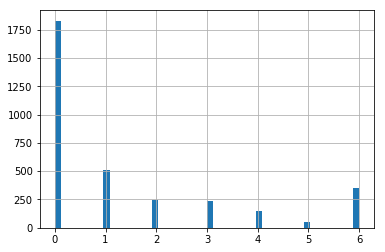

In [175]:
idx_oil.groupby(["Скважина"])["Нефть, т"].transform(lambda a: np.sum(pd.isnull(a))).hist(bins=50)

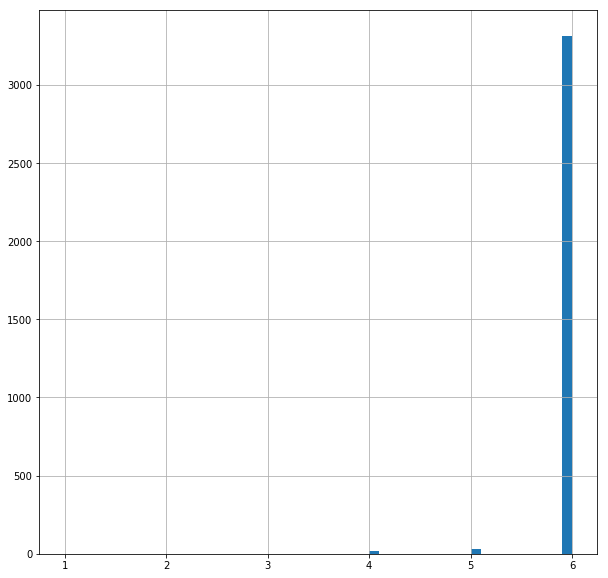

In [188]:
idx_oil.groupby(["Скважина"])["Нефть, т"].transform(lambda a: len(a)).hist(bins=50, figsize=(10,10))

In [190]:
#train first step predictors_here
y_train_clear = y_train[y_train.notnull()]